In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

### Data input and cleaning

In [2]:
import re
sns.set()
data = pd.read_csv("data3.csv", dtype={'time':np.float64})

data['error'] = [float(x[1:-1]) for x in data['fbest']]

def sanitize(data):
    return ''.join(filter(lambda x: x in ',.0123456789', data))

data['history'] = data['fhistorybk'].apply(sanitize)
data['frac'] = data['sol'].str.count("1")/40

data = data.join(data['freq'].str.split(', ', expand=True).apply(pd.to_numeric))

data.drop(["fbest", "freq", "Unnamed: 0", "fhistory", "fhistorybk"], axis=1, inplace=True)
    
data.rename(columns=lambda x: x+1 if type(x)==int else x, inplace=True)

pd.set_option('display.max_rows', 1000)
data.sort_values(by=["error"]).drop(['crossover', 'errorLimit', 'nPop', 'time', 'history', 'frac'], axis=1)

,f1,grad,sol,error,1,2,3,4,5,6
77,50,150,1001100100011110011001100110011000000110,9.132734,50.744202,205.529368,323.478849,486.117977,661.302099,818.587113
7,75,150,1101110111011111111110010110000000001100,12.811697,76.151208,237.982306,353.832796,495.242567,717.042918,866.829913
57,75,150,0111101010111110010101000110011000000000,14.082155,71.390280,222.858013,343.570073,533.598842,742.290021,836.456364
107,75,150,0111011111011110001000110010011000001000,14.374299,73.577452,225.627660,330.342983,515.096312,712.031183,868.244407
82,75,150,1111101100111110110001000100010000000100,15.093967,74.631858,224.988185,330.541789,529.513782,733.796633,851.630352
58,75,200,1110111110011110011001100110011000010000,16.347796,75.641457,285.779486,410.362187,620.199062,873.352218,1073.158072
108,75,200,1110011111010111011101110111001001000000,16.464633,77.584811,268.370395,406.384656,637.651851,898.572797,1103.144231
1,50,100,0010101110110000010001000010000000000000,16.466083,45.377754,150.709160,231.655692,339.398243,469.863939,605.804010
102,50,150,1001100001111111110001100110000100100000,17.108291,51.264818,196.815793,316.931684,477.902967,735.243128,813.802350
32,75,150,0110111110011110111111111111001000000001,17.115247,68.468801,228.803816,338.132758,522.153630,713.458078,900.985396


In [3]:
errors = data.drop(['crossover', 'errorLimit', 'nPop', 'sol', 'time', 'history', 'frac'], axis=1)
errors.drop([x for x in errors.columns if type(x)==int], axis=1, inplace=True)
mean_errors = errors.groupby(["f1", "grad"], as_index=False).mean()

In [4]:
mean_errors = mean_errors.pivot("f1", "grad", "error")
mean_errors / 6

grad,50,100,150,200,250
f1,,,,,
50,15.492384,3.226400,2.750257,4.805961,7.221823
75,15.665160,5.333368,2.449245,3.073075,4.776527
100,15.692863,7.727036,4.396045,4.224316,5.338968
125,15.471441,8.569302,5.619588,6.087545,6.865727
150,15.550009,9.657882,6.758325,7.629209,8.580651


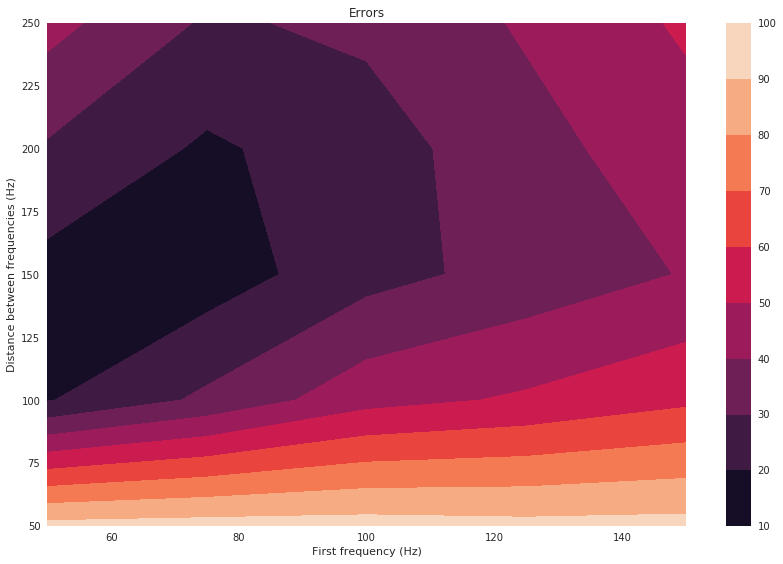

In [5]:
plt.figure(figsize=(12,8))

x = mean_errors.columns.values
y = mean_errors.index.values
Z = mean_errors.values
Y ,X = np.meshgrid(x, y)
CS = plt.contourf(X, Y, Z)
plt.xlabel("First frequency (Hz)")
plt.ylabel("Distance between frequencies (Hz)")
plt.title("Errors")
plt.colorbar()

plt.tight_layout()
plt.show()

In [6]:
E1 = 3.45e9
E0 = 115e6

p1 = 2950
p0 = 1072.5

L = 0.1

errors_nd = data.drop(['crossover', 'errorLimit', 'nPop', 'sol', 'time', 'history'], axis=1)
errors_nd.drop([x for x in errors_nd.columns if type(x)==int], axis=1, inplace=True)
factor = np.sqrt(((E1 - E0) * np.mean(errors_nd['frac']) + E0) / ((p1 - p0) * np.mean(errors_nd['frac']) + p0)) / L
errors_nd['f1'] = errors_nd['f1'] / factor
errors_nd['grad'] = errors_nd['grad'] / factor

errors_nd = errors_nd.drop(['frac'], axis=1)
mean_errors_nd = errors_nd.groupby(["f1", "grad"], as_index=False).mean()
mean_errors_nd = mean_errors_nd.pivot("f1", "grad", "error")

mean_errors_nd.head()

grad,0.005296842837919613,0.010593685675839227,0.015890528513758842,0.021187371351678454,0.02648421418959807
f1,,,,,
0.005297,92.954306,19.358398,16.501543,28.835767,43.330936
0.007945,93.990960,32.000206,14.695473,18.438447,28.659161
0.010594,94.157175,46.362215,26.376269,25.345895,32.033805
0.013242,92.828644,51.415814,33.717527,36.525270,41.194363
0.015891,93.300052,57.947290,40.549948,45.775254,51.483905


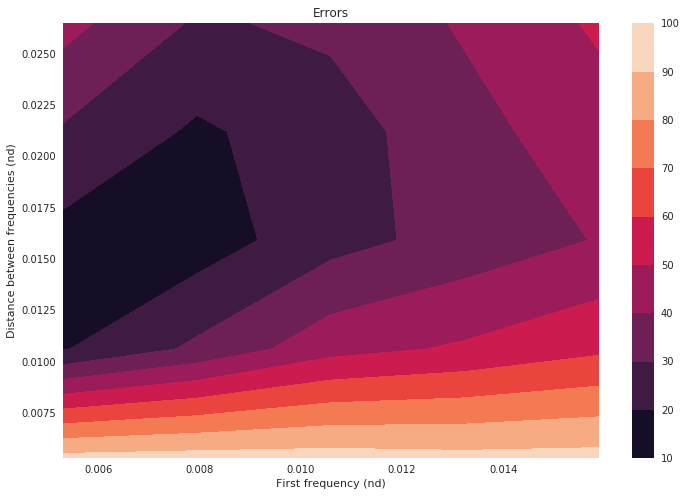

In [7]:
plt.figure(figsize=(12,8))

x = mean_errors_nd.columns.values
y = mean_errors_nd.index.values
Z = mean_errors_nd.values
Y ,X = np.meshgrid(x, y)
CS = plt.contourf(X, Y, Z)
plt.xlabel("First frequency (nd)")
plt.ylabel("Distance between frequencies (nd)")
plt.title("Errors")
plt.colorbar()
plt.show()

In [8]:
history = data.drop(['crossover', 'errorLimit', 'nPop', 'sol', 'time', 'frac', 'error'], axis=1)
history.drop([x for x in history.columns if type(x)==int], axis=1, inplace=True)
history = pd.concat([history, history['history'].str.split(',', expand=True).apply(pd.to_numeric)], axis=1)
history.drop(["history"], axis=1, inplace=True)
history.head()

,f1,grad,0,1,2,3,4,5,6,7,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,50,50,118.387062,118.387062,109.885892,106.132216,106.132216,103.447008,103.447008,103.447008,...,93.083906,93.083906,93.083906,93.083906,93.083906,93.083906,93.083906,93.083906,93.083906,93.083906
1,50,100,38.773122,38.773122,33.146701,27.023412,27.023412,27.023412,27.023412,27.023412,...,16.466083,16.466083,16.466083,16.466083,16.466083,16.466083,16.466083,16.466083,16.466083,16.466083
2,50,150,27.234110,27.234110,27.234110,27.234110,23.058660,23.058660,23.058660,23.058660,...,18.599142,18.599142,18.599142,18.599142,18.599142,18.599142,18.599142,18.599142,18.599142,18.599142
3,50,200,42.899875,40.489248,40.489248,40.489248,40.489248,40.131152,40.131152,40.131152,...,30.310424,30.310424,30.310424,30.310424,30.310424,30.310424,30.310424,30.310424,30.310424,30.310424
4,50,250,60.395780,60.395780,57.976099,57.976099,57.709084,57.709084,57.709084,55.568792,...,44.279468,44.279468,44.279468,44.279468,44.279468,44.279468,44.279468,44.279468,44.279468,44.279468
